In [1]:
# A single-file scripts for running the ellipse experiment, 
# no confounders were included in Eq. 4 during model training.
import pandas as pd
import numpy as np
import cv2 as cv
import glob
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
from PIL import Image, ImageOps
import cv2
import imgaug as ia
from imgaug import augmenters as iaa
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
import sys
import torch.optim as optim
import math
sys.path.append(".")
from sklearn.feature_selection import mutual_info_regression
import dcor



In [2]:
# define the autoencoder model------------------------------------


class Encoder(nn.Module):
    def __init__(self, nc, nef, nz, isize, device):
        super(Encoder, self).__init__()

        # Device
        self.device = device

        # Encoder: (nc, isize, isize) -> (nef*8, isize//16, isize//16)
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, nef, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef),

            nn.Conv2d(nef, nef*2, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*2),

            nn.Conv2d(nef*2, nef*4, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*4),

            nn.Conv2d(nef*4, nef*8, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*8)
        )

        # Map the encoded feature map to the latent vector of mean, (log)variance
        out_size = isize // 16
        self.mean = nn.Linear(nef*8*out_size*out_size, nz)
        self.logvar = nn.Linear(nef*8*out_size*out_size, nz)

    def reparametrize(self, mean, logvar):
        std = logvar.mul(0.5).exp_()
        multi_norm = torch.FloatTensor(std.size()).normal_().to(self.device)
        multi_norm = Variable(multi_norm)
        return multi_norm.mul(std).add_(mean)

    def forward(self, inputs):
        # Batch size
        batch_size = inputs.size(0)
        # Encoded feature map
        hidden = self.encoder(inputs)
        # Reshape
        hidden = hidden.view(batch_size, -1)
        # Calculate mean and (log)variance
        mean, logvar = self.mean(hidden), self.logvar(hidden)
        # Sample
        latent_z = self.reparametrize(mean, logvar)
        #latent_z = mean
        return latent_z, mean, logvar

class Decoder(nn.Module):
    def __init__(self, nc, ndf, nz, isize):
        super(Decoder, self).__init__()

        # Map the latent vector to the feature map space
        self.ndf = ndf
        self.out_size = isize // 16
        self.decoder_dense = nn.Sequential(
            nn.Linear(nz, ndf*8*self.out_size*self.out_size),
            nn.ReLU(True)
        )
        # Decoder: (ndf*8, isize//16, isize//16) -> (nc, isize, isize)
        self.decoder_conv = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*8, ndf*4, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*4, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*4, ndf*2, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*2, 1.e-3),
        
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*2, ndf, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf, nc, 3, padding=1),
            nn.ReLU(True)
        )

    def forward(self, input):
        batch_size = input.size(0)
        hidden = self.decoder_dense(input).view(
            batch_size, self.ndf*8, self.out_size, self.out_size)
        output = self.decoder_conv(hidden)
        return output

class VAE(nn.Module):
    def __init__(self, nc=1, ndf=4, nef=4, nz=8, isize=64, device=torch.device("cuda:0"), is_train=True):
        super(VAE, self).__init__()

        self.nz = nz
        # Encoder
        self.encoder = Encoder(nc=nc, nef=nef, nz=nz, isize=isize, device=device)
        # Decoder
        self.decoder = Decoder(nc=nc, ndf=ndf, nz=nz, isize=isize)
        self.pe = nn.Linear(nz, 1, bias=False)
        if is_train == False:
            for param in self.encoder.parameters():
                param.requires_grad = False
            for param in self.decoder.parameters():
                param.requires_grad = False

    def forward(self, x):
        latent_z, mean, logvar = self.encoder(x)
        rec_x = self.decoder(latent_z)
        zp = self.pe(latent_z)

        return rec_x, mean, logvar, latent_z, zp, 
    
    def encode(self, x):
        latent_z, _, _ = self.encoder(x)
        return latent_z

    def decode(self, z):
        return self.decoder(z)

In [3]:
#loss functions---------------------------------

def torch_corr(input1, input2, device):  #The correlation loss function

    mean_1 = torch.mean(input1)
    mean_2 = torch.mean(input2)
    var_1 = torch.var(input1)
    var_2 = torch.var(input2)
    vector_mean1 = mean_1*torch.ones([len(input1)]).to(device)
    vector_mean2 = mean_2*torch.ones([len(input2)]).to(device)
    #print(input2, vector_mean2)
    diff_1 = input1 - vector_mean1
    diff_2 = input2 - vector_mean2

    exp = torch.mul(diff_1,diff_2)
    exp = torch.sum(exp)   


    exp = exp / len(input1)
    exp = exp / torch.sqrt(var_1*var_2)
    return abs(exp)


class KLDLoss(nn.Module):
    def __init__(self, reduction='sum'):
        super(KLDLoss, self).__init__()
        self.reduction = reduction

    def forward(self, mean, logvar):
        # KLD loss
        kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), 1)
        # Size average
        if self.reduction == 'mean':
            kld_loss = torch.mean(kld_loss)
        elif self.reduction == 'sum':
            kld_loss = torch.sum(kld_loss)
        return kld_loss
    


In [4]:
# data loader----------------------------------


class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Sometimes(0.4,\
            iaa.ContrastNormalization((0.8, 1.2), per_channel=0.5)),
        iaa.Sometimes(0.4,\
            iaa.GaussianBlur(sigma=(0, 0.2))),
    ])
      
  def __call__(self, img):
    img = np.array(img)
    img = self.aug.augment_image(img)
    return img

class ImageDataset(Dataset):
    def __init__(self, paths_image,is_aug=False):
        super(ImageDataset, self).__init__()

        # Length
        self.length = len(paths_image)
        # Image path
        self.paths_image = paths_image

        # Augment
        self.is_aug = is_aug
        self.transform = transforms.Compose([
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            ImgAugTransform(),
            lambda x: Image.fromarray(x),
        ])
        # Preprocess
        self.output = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            ])

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Image
        img = Image.open(self.paths_image[idx].strip())  # Strip any extra whitespace or newline characters
        img = self.output(img)

        # File name parsing
        file_name = self.paths_image[idx].strip()  # Ensure no whitespace issues
        file_name_no_ext = file_name.split('/')[-1].replace('.png', '')  # Get just the filename without the path or extension

        # Split filename into components
        split_file_name = file_name_no_ext.split('_')
        #print(split_file_name)
        if len(split_file_name) == 5:  # Check for correct format (imageID_area_rotation_position_brightness)
            imageID = split_file_name[0]
            area = float(split_file_name[1])           # Convert area to float
            rotation = float(split_file_name[2])       # Convert rotation to float
            position = float(split_file_name[3])       # Convert position to float
            brightness = float(split_file_name[4])     # Convert brightness to float

            # Normalize brightness if needed
            normalized_brightness = float(brightness/255)
        else:
            raise ValueError("Filename format is incorrect. Ensure it follows '{imageID}_{area}_{rotation}_{position}_{brightness}.png'")

        return img, area, rotation, position, normalized_brightness, imageID
    


# this dataloader was implemented with class 'ImageDataset' for dynamic memory control
def get_celeba_loaders(batch_train, batch_test):
    f_train = open('/ellipse_dataset/folds_split/train_fold_5.txt','r')      # paths for input
    file_list_train = f_train.readlines()

    f_test = open('/ellipse_dataset/folds_split/test_fold_5.txt','r')      # paths for input
    file_list_test = f_test.readlines()

    datasets = {
        "train":  ImageDataset(file_list_train,True),
        "test": ImageDataset(file_list_test, False)
    }

    dataloaders = {
        "train": DataLoader(  datasets["train"],  batch_size=batch_train, shuffle=True),
        "test": DataLoader( datasets["test"], batch_size=batch_test, shuffle=False)
    }
    return dataloaders




In [5]:
# display functions--------------------------


if "DISPLAY" not in os.environ:
    plt.switch_backend("Agg")

def plot_loss(dirname, history):
    """ Plot loss """

    plot_train = np.array(history["train"])
    is_val = ("test" in history.keys())
    if is_val:
        plot_val = np.array(history["test"])

    if not os.path.exists(dirname):
        os.makedirs(dirname)

    # epochs
    n_epochs = len(plot_train)

    # X axis
    x = [i for i in range(1, n_epochs+1)]
    
    # plot loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.xlabel('epoch')
    plt.plot(x, plot_train[:], label='train loss')
    if is_val:
        plt.plot(x, plot_val[:], label='test loss')

    plt.legend()
    plt.savefig(os.path.join(dirname,'loss.png'))
    plt.close()

def imsave(x, rec_x, path, row=2, col=2):
    """ Save the first row*col images """
    #print(x.size())
    #exit(0)
    # Save dir
    save_dir = os.path.dirname(path)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # To cpu, numpy, uint8 format and (num, h, w, c) shape
    in_imgs = (x.clone().cpu().detach().numpy()[:row*col]*255)\
        .astype(np.uint8).transpose(0, 2, 3, 1)[:, :, :, ::-1]
    out_imgs = (rec_x.clone().cpu().detach().numpy()[:row*col]*255)\
        .astype(np.uint8).transpose(0, 2, 3, 1)[:, :, :, ::-1]

    # Reshape
    in_imgs = cv2.vconcat([cv2.hconcat([in_imgs[i+j] for j in range(0, col)])
        for i in range(0, row*col, col)])
    out_imgs = cv2.vconcat([cv2.hconcat([out_imgs[i+j] for j in range(0, col)])
        for i in range(0, row*col, col)])
   # print(in_imgs.shape)
    #exit(0)
    # Concat
    h, _,  = in_imgs.shape
    margin_shape = (h, 5 )
    margin = np.ones(margin_shape, np.uint8) * 255
    concat_imgs = cv2.hconcat([in_imgs, margin, out_imgs])

    # Save
    cv2.imwrite(path, concat_imgs)

def imsave_inp(x, path, row=1, col=11):
    """ Save the interpolated images """

    # Save dir
    save_dir = os.path.dirname(path)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # To cpu, numpy, uint8 format and (num, h, w, c) shape
    in_imgs = (x.clone().cpu().detach().numpy()[:row*col]*255)\
        .astype(np.uint8).transpose(0, 2, 3, 1)[:, :, :, ::-1]

    # Reshape
    in_imgs = cv2.vconcat([cv2.hconcat([in_imgs[i+j] for j in range(0, col)])
        for i in range(0, row*col, col)])

    # Save
    cv2.imwrite(path, in_imgs)

class Logger:
    def __init__(self, path):
        self.f = open(path, 'w')

    def __del__(self):
        self.f.close()

    def write(self, text):
        self.f.write(text+"\n")
        self.f.flush()
        print(text)

In [6]:
# training------------------------

# Device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
epochs=300
batch_train = 32
batch_test = 64
eta = 2.0 ## see Eq. 3 in the paper     if eta==0, then disable confounder correction
lambda_par=8000 # see Eq. 5 in the paper
# Dataloader
dataloaders = get_celeba_loaders(batch_train, batch_test) # train batch size : 16;  test batch size: 64
# Model
model = VAE(device=device).to(device)


reconst_criterion = nn.MSELoss(reduction='sum')

kld_criterion = KLDLoss(reduction='sum')

# Solver
optimizer = optim.Adam(model.parameters(), lr=0.005)
# Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.97, last_epoch=-1)

#----model lr, see t^=LR(zp) in the manuscript

model_lr = torch.nn.Linear(1,1).to(device)
optimizer_lr = optim.Adam(model_lr.parameters(), lr=0.05)
scheduler_lr = optim.lr_scheduler.StepLR(optimizer_lr, 1, gamma=0.97, last_epoch=-1)
#----
# Log
logdir = './log/pvae'

if not os.path.exists(logdir):
    os.makedirs(logdir)
# Logger
logger = Logger(os.path.join(logdir, "log.txt"))
# History
history = {"train": [], "test": []}


# Start training
for epoch in range(epochs):
    num_list, pos_list, rot_list, zp_list, bri_list,logit_out_list = [],[],[],[],[],[]
    mse_loss_total = 0
    for phase in ["train", "test"]:
        if phase == "train":
            model.train(True)
            model_lr.train(True)
            logger.write(f"\n----- Epoch {epoch+1} -----")
        else:
            model.train(False)
            model_lr.train(False)
        # Loss
        running_loss = 0.0
        # Data num
        data_num = 0

        i = 0
        i_test = 0
        for data in dataloaders[phase]:
            x = data[0].to(device)
            num_t = data[1].to(device) #area
            rot_t = data[2].to(device) #ratation
            pos_t = data[3].to(device) #position
            bri_t = data[4].to(device) #brightness
            id_name = data[5]
            #print(num_t,col_t,red_t,id_name)
            #print(num_t, col_t,id_name)
            #exit(0)
            # Optimize params

            if phase == "train":
                optimizer.zero_grad()
                if len(num_t) != batch_train:
                    continue
                # Pass forward
                x = x.to(device)
                rec_x, mean, logvar, latent_z , zp  = model(x)
                # Calc loss
                zp = zp.view([len(num_t)])
                corr_loss = - torch_corr(zp, bri_t,device) #+ eta*torch_corr(zp, rot_t, device)+eta*torch_corr(zp, pos_t, device)#+eta*torch_corr(zp, num_t, device)
                reconst_loss =  reconst_criterion(rec_x, x)
                kld_loss = kld_criterion(mean, logvar)
                loss =  lambda_par*corr_loss+  reconst_loss +  kld_loss
                loss.backward()
                optimizer.step()
                #-------finish the update of the proposed AI model

                optimizer_lr.zero_grad()
                rec_x, _, _, _ , zp= model(x)
                #print(zp.size())
                logit_out = model_lr(zp)
                logit_out = logit_out.view([len(logit_out)])
                #print(logit_out.size(), bri_t.size())
                loss_lr = F.mse_loss(logit_out.float(), bri_t.float(),reduction='mean')
                loss_lr.backward()
                optimizer.zero_grad()
                optimizer_lr.step()
                # ------------------------finish the update of the LR model
                x[x<0]=0
                rec_x[rec_x<0]=0
                x[x>1]=1
                rec_x[rec_x>1]=1
                # Visualize
                if i == 0 and x.size(0) >= batch_train:
                    imsave(x, rec_x, os.path.join(logdir, f"epoch{epoch+1}", f"train.png"), 2, 4)
    
            elif phase == "test":
                with torch.no_grad():
                    optimizer.zero_grad()
                    # Pass forward
                    x = x.to(device)
                    rec_x, mean, logvar, latent_z, zp= model(x)
                    logit_out = model_lr(zp)
                    zp = zp.view([len(num_t)])
                    logit_out = logit_out.view([len(num_t)])
                    #print(logit_out.size(), col_t.size())
                    loss_lr_test = F.mse_loss(logit_out.float(), bri_t.float(),reduction='mean')
                    num_list = np.append(num_list, num_t.cpu().numpy())
                    pos_list = np.append(pos_list, pos_t.cpu().numpy())
                    logit_out_list = np.append(logit_out_list, logit_out.cpu().numpy())
                    rot_list = np.append(rot_list, rot_t.cpu().numpy())
                    bri_list = np.append(bri_list, bri_t.cpu().numpy())
                    zp_list = np.append(zp_list, zp.cpu().numpy())
                    # Calc loss
                    mse_loss_total = mse_loss_total +loss_lr_test.item()
                    diy_l1loss = nn.L1Loss(reduction='mean')
                    loss = diy_l1loss(rec_x, x)  #L1 loss for Table 1 in the manuscript
                    x[x<0]=0
                    rec_x[rec_x<0]=0
                    x[x>1]=1
                    rec_x[rec_x>1]=1
                    if i_test == 0 and x.size(0) >= 16:
                        imsave(x, rec_x, os.path.join(logdir, f"epoch{epoch+1}", f"test-{i}.png"), 8, 8)
                        i_test = i_test + 1

            i = i + 1
            # Add stats

            running_loss += loss  #* x.size(0)
            data_num +=1

        # Log

        epoch_loss = running_loss / data_num
        history[phase].append(epoch_loss)
        if phase == "test":
            logger.write(f"{phase} L1-Loss : {epoch_loss:.4f}")        

        #if phase == "test":
        #    plot_loss(logdir, history)
#-----
    mse_loss_total = mse_loss_total/len(dataloaders["test"])
    #print('data_num:, len_dataloader:', data_num, len(dataloaders["test"]))
    scheduler.step()
    scheduler_lr.step()

    bri_list=np.array(bri_list)
    #zp2_list=np.array(zp2_list)
    rot_list=np.array(rot_list)
    num_list=np.array(num_list)
    pos_list=np.array(pos_list)

    corr_loss_radius = np.corrcoef(zp_list, num_list)[0,1]   #the correlation coefficient in the test set should be global-population-level, instead of batch-level
    corr_loss_rot = np.corrcoef(zp_list, rot_list)[0,1]
    corr_loss_pos = np.corrcoef(zp_list, pos_list)[0,1]
    corr_loss_bri = np.corrcoef(zp_list, bri_list)[0,1]
    epoch_zp_64 = zp_list.astype(np.float64)
    epoch_radius_64 = num_list.astype(np.float64)
    epoch_pos_64 = pos_list.astype(np.float64)
    epoch_rot_64 = rot_list.astype(np.float64)
    epoch_bri_64 = bri_list.astype(np.float64)
    
    mi_bri = mutual_info_regression(zp_list.reshape(-1,1), bri_list.reshape(-1))
    mi_radius = mutual_info_regression(zp_list.reshape(-1,1), num_list.reshape(-1))
    mi_pos = mutual_info_regression(zp_list.reshape(-1,1), pos_list.reshape(-1))
    mi_rot = mutual_info_regression(zp_list.reshape(-1,1), rot_list.reshape(-1))

    dcor_bri = dcor.u_distance_correlation_sqr(epoch_zp_64.reshape(-1, 1), epoch_bri_64)
    dcor_radius = dcor.u_distance_correlation_sqr(epoch_zp_64.reshape(-1, 1), epoch_radius_64)
    dcor_pos = dcor.u_distance_correlation_sqr(epoch_zp_64.reshape(-1, 1), epoch_pos_64)
    dcor_rot = dcor.u_distance_correlation_sqr(epoch_zp_64.reshape(-1, 1), epoch_rot_64)
    
    
    print('corr in test set: brighenss, angle, position, area', corr_loss_bri,corr_loss_rot,corr_loss_pos,corr_loss_radius)
    print('dcor2 in test set: brighenss, angle, position, area', dcor_bri, dcor_rot,dcor_pos, dcor_radius)
    print('MI in test set: brighenss, angle, position, area', mi_bri, mi_rot,mi_pos, mi_radius)
    print('r-mse_loss of brightness in test set:',np.sqrt(mse_loss_total)) 
    #print('corr_num2, corr_col2', corr_loss_num2,corr_loss_col2)
    #torch.save(model.state_dict(),\
    #    os.path.join(logdir, 'final_model'+str(epoch)+'.pth'))



/home/lau/codes/env/lib/python3.6/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)



----- Epoch 1 -----
test L1-Loss : 0.0201
corr in test set: brighenss, angle, position, area 0.994191000254025 0.3775312170436878 0.38276438173927846 -0.4062254000151601
dcor2 in test set: brighenss, angle, position, area 0.9838590797675859 0.11118246865157402 0.11665743445343048 0.1396650345901436
MI in test set: brighenss, angle, position, area [2.32818877] [0.06425342] [0.09210472] [0.08923125]
r-mse_loss of brightness in test set: 0.03746596066754253

----- Epoch 2 -----
test L1-Loss : 0.0181
corr in test set: brighenss, angle, position, area 0.9948088606100088 0.34955084248084534 0.39773669375027126 -0.45286726954858436
dcor2 in test set: brighenss, angle, position, area 0.9860433005051524 0.09419175341774629 0.12901837337982214 0.17183149619993385
MI in test set: brighenss, angle, position, area [2.42778545] [0.07607707] [0.08526982] [0.1184085]
r-mse_loss of brightness in test set: 0.03604225835619976

----- Epoch 3 -----
test L1-Loss : 0.0155
corr in test set: brighenss, angle

test L1-Loss : 0.0098
corr in test set: brighenss, angle, position, area 0.9971021717539651 0.3772156100725655 0.40441955872425855 -0.4196893710263461
dcor2 in test set: brighenss, angle, position, area 0.9915189676646148 0.10875699681809274 0.13149280402064215 0.1469108410309487
MI in test set: brighenss, angle, position, area [2.6231091] [0.07475814] [0.09121373] [0.09419086]
r-mse_loss of brightness in test set: 0.011860868414547272

----- Epoch 20 -----
test L1-Loss : 0.0091
corr in test set: brighenss, angle, position, area 0.9971468461496037 0.37615737532762045 0.398367787235507 -0.4073318153355214
dcor2 in test set: brighenss, angle, position, area 0.9916155784528575 0.10875882357004324 0.12794780360704364 0.1402827085164644
MI in test set: brighenss, angle, position, area [2.64706398] [0.10191024] [0.08389955] [0.10670971]
r-mse_loss of brightness in test set: 0.0116409818533389

----- Epoch 21 -----
test L1-Loss : 0.0119
corr in test set: brighenss, angle, position, area 0.996

test L1-Loss : 0.0072
corr in test set: brighenss, angle, position, area 0.9979847938745123 0.3713071350812337 0.40055336959965626 -0.42369472217550075
dcor2 in test set: brighenss, angle, position, area 0.9938010590302689 0.10549426581110562 0.13001665328650017 0.15046437002446802
MI in test set: brighenss, angle, position, area [2.81131053] [0.08955109] [0.08628961] [0.08139385]
r-mse_loss of brightness in test set: 0.020919883082340242

----- Epoch 38 -----
test L1-Loss : 0.0074
corr in test set: brighenss, angle, position, area 0.9975937711471744 0.36779801737705886 0.4170251322610505 -0.41337641062419045
dcor2 in test set: brighenss, angle, position, area 0.9927230939213166 0.1037589480097317 0.14299263871879403 0.1430165882223442
MI in test set: brighenss, angle, position, area [2.68292363] [0.09382104] [0.0877428] [0.08983334]
r-mse_loss of brightness in test set: 0.011510899939499393

----- Epoch 39 -----
test L1-Loss : 0.0070
corr in test set: brighenss, angle, position, area 

test L1-Loss : 0.0101
corr in test set: brighenss, angle, position, area 0.9975444158307575 0.3699301679812506 0.4001361958332805 -0.4389000838162313
dcor2 in test set: brighenss, angle, position, area 0.9926114865917243 0.10461881361965526 0.13118211878209662 0.16044275303686484
MI in test set: brighenss, angle, position, area [2.70762874] [0.08525532] [0.06966094] [0.09746686]
r-mse_loss of brightness in test set: 0.022594371642872327

----- Epoch 56 -----
test L1-Loss : 0.0078
corr in test set: brighenss, angle, position, area 0.9981667616293328 0.37476328267409914 0.40420754732643366 -0.42338493592291987
dcor2 in test set: brighenss, angle, position, area 0.9942723602356692 0.10661198986356057 0.13439471570364891 0.1506203402384783
MI in test set: brighenss, angle, position, area [2.84329706] [0.0933478] [0.08129406] [0.09105195]
r-mse_loss of brightness in test set: 0.012736908792314587

----- Epoch 57 -----
test L1-Loss : 0.0066
corr in test set: brighenss, angle, position, area 

test L1-Loss : 0.0069
corr in test set: brighenss, angle, position, area 0.9978965081942252 0.3748886693700504 0.39189980949786024 -0.4252280668904143
dcor2 in test set: brighenss, angle, position, area 0.993304241585577 0.10800986145617211 0.12479364869468802 0.1521919465370668
MI in test set: brighenss, angle, position, area [2.7766581] [0.09451002] [0.08103754] [0.07694096]
r-mse_loss of brightness in test set: 0.010254831669691438

----- Epoch 74 -----
test L1-Loss : 0.0064
corr in test set: brighenss, angle, position, area 0.9979093907118016 0.379144001911555 0.3991052436661875 -0.41794041709599655
dcor2 in test set: brighenss, angle, position, area 0.9936506589654229 0.1109156433678086 0.12907185501742066 0.1467850867863527
MI in test set: brighenss, angle, position, area [2.77702923] [0.05701645] [0.07735533] [0.08645105]
r-mse_loss of brightness in test set: 0.01163169169480649

----- Epoch 75 -----
test L1-Loss : 0.0065
corr in test set: brighenss, angle, position, area 0.9982

test L1-Loss : 0.0062
corr in test set: brighenss, angle, position, area 0.9983782330023573 0.3684431523633857 0.4047592217907602 -0.4181959763363727
dcor2 in test set: brighenss, angle, position, area 0.9949469093131985 0.1037806609397745 0.13296894072677254 0.14684608785872466
MI in test set: brighenss, angle, position, area [2.89277966] [0.11657024] [0.05964512] [0.07058282]
r-mse_loss of brightness in test set: 0.009441486458177266

----- Epoch 92 -----
test L1-Loss : 0.0062
corr in test set: brighenss, angle, position, area 0.9983369582479442 0.3698905602698297 0.40031950396571125 -0.42052965653890356
dcor2 in test set: brighenss, angle, position, area 0.9948225385765385 0.10525702564213968 0.12948568978551678 0.148491741978126
MI in test set: brighenss, angle, position, area [2.93170168] [0.09745903] [0.07361169] [0.10044124]
r-mse_loss of brightness in test set: 0.009426403149374325

----- Epoch 93 -----
test L1-Loss : 0.0065
corr in test set: brighenss, angle, position, area 0.

test L1-Loss : 0.0063
corr in test set: brighenss, angle, position, area 0.9981648699174714 0.37519675398464275 0.4006319295981837 -0.42301199145570634
dcor2 in test set: brighenss, angle, position, area 0.9942352427987007 0.10782380987680139 0.13020626362389992 0.15028368163296602
MI in test set: brighenss, angle, position, area [2.85464613] [0.107571] [0.07176974] [0.09108922]
r-mse_loss of brightness in test set: 0.012214159648468531

----- Epoch 110 -----
test L1-Loss : 0.0061
corr in test set: brighenss, angle, position, area 0.9980623698975019 0.3724148101236705 0.39623488373809346 -0.4235349657388197
dcor2 in test set: brighenss, angle, position, area 0.9939553999269638 0.10610619904771636 0.1274536249404755 0.15106995447875754
MI in test set: brighenss, angle, position, area [2.80999185] [0.0795983] [0.11198036] [0.12403642]
r-mse_loss of brightness in test set: 0.00934437123188266

----- Epoch 111 -----
test L1-Loss : 0.0062
corr in test set: brighenss, angle, position, area 0

test L1-Loss : 0.0064
corr in test set: brighenss, angle, position, area 0.9980632655953326 0.3710185859004969 0.3970978822658045 -0.4214581214573303
dcor2 in test set: brighenss, angle, position, area 0.9939255060949553 0.10581731556937075 0.1292825984622681 0.14860911712865607
MI in test set: brighenss, angle, position, area [2.83943301] [0.12263691] [0.09788833] [0.11157194]
r-mse_loss of brightness in test set: 0.013779990555911356

----- Epoch 128 -----
test L1-Loss : 0.0063
corr in test set: brighenss, angle, position, area 0.9982167362552227 0.3688464592170976 0.39907976562048675 -0.42345853200112893
dcor2 in test set: brighenss, angle, position, area 0.9945923725851913 0.1042324835184733 0.1301040593276139 0.15057001656110122
MI in test set: brighenss, angle, position, area [2.82123165] [0.08993463] [0.10697766] [0.10656469]
r-mse_loss of brightness in test set: 0.009559608818691343

----- Epoch 129 -----
test L1-Loss : 0.0062
corr in test set: brighenss, angle, position, area 

test L1-Loss : 0.0063
corr in test set: brighenss, angle, position, area 0.9981127626845817 0.37425353849745807 0.3980578118875346 -0.42039793919366686
dcor2 in test set: brighenss, angle, position, area 0.9940590617208052 0.10748152997735769 0.12865544286245395 0.1485541993808075
MI in test set: brighenss, angle, position, area [2.86060264] [0.06349402] [0.10887578] [0.10332588]
r-mse_loss of brightness in test set: 0.014884236375899815

----- Epoch 146 -----
test L1-Loss : 0.0061
corr in test set: brighenss, angle, position, area 0.9983625681946895 0.3744345782510761 0.3945325783320409 -0.41913747668863705
dcor2 in test set: brighenss, angle, position, area 0.994948859079479 0.10755816309529856 0.1261712514787605 0.14670503680363922
MI in test set: brighenss, angle, position, area [2.8931856] [0.12143841] [0.06614333] [0.11135262]
r-mse_loss of brightness in test set: 0.01361705749203989

----- Epoch 147 -----
test L1-Loss : 0.0062
corr in test set: brighenss, angle, position, area 0

test L1-Loss : 0.0060
corr in test set: brighenss, angle, position, area 0.9982290798505218 0.37194131378724105 0.40087939851586635 -0.41876962358083253
dcor2 in test set: brighenss, angle, position, area 0.9943844888023434 0.1065459685069629 0.13043765023109322 0.14669685526064954
MI in test set: brighenss, angle, position, area [2.85365267] [0.09468253] [0.1011605] [0.06932526]
r-mse_loss of brightness in test set: 0.009038937180867923

----- Epoch 164 -----
test L1-Loss : 0.0062
corr in test set: brighenss, angle, position, area 0.9980838994272172 0.37156025577908425 0.39473023043180044 -0.41884377061835737
dcor2 in test set: brighenss, angle, position, area 0.9942995090040804 0.10573347661640435 0.12728659206342405 0.14679434164101735
MI in test set: brighenss, angle, position, area [2.83162541] [0.10508483] [0.07515637] [0.09341022]
r-mse_loss of brightness in test set: 0.008712120082125617

----- Epoch 165 -----
test L1-Loss : 0.0062
corr in test set: brighenss, angle, position, 

test L1-Loss : 0.0061
corr in test set: brighenss, angle, position, area 0.9980914831134382 0.3737458631224074 0.3975729301587477 -0.421583089848168
dcor2 in test set: brighenss, angle, position, area 0.9941021261992842 0.10728932577521864 0.12814015175458587 0.14881320353617591
MI in test set: brighenss, angle, position, area [2.81203295] [0.07247093] [0.09163411] [0.09127671]
r-mse_loss of brightness in test set: 0.010327651795617083

----- Epoch 182 -----
test L1-Loss : 0.0062
corr in test set: brighenss, angle, position, area 0.9981157163944802 0.3701147513229077 0.3974002815398195 -0.42021487389843565
dcor2 in test set: brighenss, angle, position, area 0.9942142140234049 0.10571778029460109 0.12723120355955592 0.14841360425362052
MI in test set: brighenss, angle, position, area [2.847141] [0.09175329] [0.07315429] [0.11182299]
r-mse_loss of brightness in test set: 0.016045160524708616

----- Epoch 183 -----
test L1-Loss : 0.0061
corr in test set: brighenss, angle, position, area 0

test L1-Loss : 0.0060
corr in test set: brighenss, angle, position, area 0.998258458692922 0.376508334085361 0.40002495576868513 -0.4194048332350307
dcor2 in test set: brighenss, angle, position, area 0.9945983772089091 0.10947130959367035 0.1294300189677245 0.14719203127826633
MI in test set: brighenss, angle, position, area [2.87505649] [0.08022004] [0.08537844] [0.11610049]
r-mse_loss of brightness in test set: 0.010931455483162888

----- Epoch 200 -----
test L1-Loss : 0.0061
corr in test set: brighenss, angle, position, area 0.9981950373551881 0.37416477463112824 0.40139008566923184 -0.4190094408856077
dcor2 in test set: brighenss, angle, position, area 0.9944641489741003 0.10738616211924563 0.13041237852575063 0.14713513892551378
MI in test set: brighenss, angle, position, area [2.84390817] [0.10321456] [0.07494195] [0.09499487]
r-mse_loss of brightness in test set: 0.008415182551051219

----- Epoch 201 -----
test L1-Loss : 0.0062
corr in test set: brighenss, angle, position, area

test L1-Loss : 0.0060
corr in test set: brighenss, angle, position, area 0.9983061719662211 0.37126933401534945 0.39842393833509016 -0.42197517177019955
dcor2 in test set: brighenss, angle, position, area 0.9946904401752596 0.10556113846589434 0.12825801337902823 0.14962171477461836
MI in test set: brighenss, angle, position, area [2.90441236] [0.08937952] [0.11135973] [0.10098799]
r-mse_loss of brightness in test set: 0.008114805323543393

----- Epoch 218 -----
test L1-Loss : 0.0062
corr in test set: brighenss, angle, position, area 0.9982410910648222 0.37332066118975554 0.39830063168318214 -0.41885937185846284
dcor2 in test set: brighenss, angle, position, area 0.994672011344217 0.10661579709039178 0.12900691802061093 0.14742185076447933
MI in test set: brighenss, angle, position, area [2.85245485] [0.09046953] [0.06844213] [0.08932881]
r-mse_loss of brightness in test set: 0.00961393309762164

----- Epoch 219 -----
test L1-Loss : 0.0062
corr in test set: brighenss, angle, position, 

test L1-Loss : 0.0060
corr in test set: brighenss, angle, position, area 0.9982339562756891 0.37382001391071257 0.3963110595916956 -0.4221743935012345
dcor2 in test set: brighenss, angle, position, area 0.9944370312901687 0.1074865086268693 0.12793487235272524 0.14918057091411674
MI in test set: brighenss, angle, position, area [2.84813448] [0.08032636] [0.09395415] [0.11436744]
r-mse_loss of brightness in test set: 0.009076335746454731

----- Epoch 236 -----
test L1-Loss : 0.0066
corr in test set: brighenss, angle, position, area 0.9981496669562222 0.3728763461746954 0.39653068355449045 -0.4243060371079275
dcor2 in test set: brighenss, angle, position, area 0.9942614423045069 0.1065034881549023 0.12778402418070503 0.15186527760776022
MI in test set: brighenss, angle, position, area [2.81856457] [0.07744829] [0.07435994] [0.10415007]
r-mse_loss of brightness in test set: 0.014367554140669871

----- Epoch 237 -----
test L1-Loss : 0.0061
corr in test set: brighenss, angle, position, area

test L1-Loss : 0.0061
corr in test set: brighenss, angle, position, area 0.9981564305275622 0.3745746209312539 0.3978143427784333 -0.42085380084565743
dcor2 in test set: brighenss, angle, position, area 0.9940564668341241 0.10805424084465436 0.12843759903808283 0.14860558165492227
MI in test set: brighenss, angle, position, area [2.81622115] [0.10288176] [0.09991805] [0.10831652]
r-mse_loss of brightness in test set: 0.00885721565794333

----- Epoch 254 -----
test L1-Loss : 0.0061
corr in test set: brighenss, angle, position, area 0.9982631723182775 0.3735403551700068 0.39627575672422966 -0.4219681289804053
dcor2 in test set: brighenss, angle, position, area 0.9946031790211026 0.10659186718687783 0.12793569223729273 0.14953031074181589
MI in test set: brighenss, angle, position, area [2.86371669] [0.0561429] [0.08308194] [0.10432846]
r-mse_loss of brightness in test set: 0.008967902392464778

----- Epoch 255 -----
test L1-Loss : 0.0062
corr in test set: brighenss, angle, position, area

test L1-Loss : 0.0061
corr in test set: brighenss, angle, position, area 0.998163202991622 0.37026455165231825 0.400565283692729 -0.42455004062759416
dcor2 in test set: brighenss, angle, position, area 0.9942043104727913 0.10495433717267202 0.13187762270551753 0.15099372685471527
MI in test set: brighenss, angle, position, area [2.82389096] [0.1135296] [0.08303217] [0.1006122]
r-mse_loss of brightness in test set: 0.010302682100746457

----- Epoch 272 -----
test L1-Loss : 0.0060
corr in test set: brighenss, angle, position, area 0.9983766260908276 0.37177667974032097 0.3970306744779096 -0.4219117441332868
dcor2 in test set: brighenss, angle, position, area 0.9951243770401229 0.10553050058558225 0.12820894145929415 0.14923407310927744
MI in test set: brighenss, angle, position, area [2.93112839] [0.1069552] [0.1046942] [0.06181466]
r-mse_loss of brightness in test set: 0.012502806760972797

----- Epoch 273 -----
test L1-Loss : 0.0063
corr in test set: brighenss, angle, position, area 0.

test L1-Loss : 0.0061
corr in test set: brighenss, angle, position, area 0.9981186444922859 0.37322621260345507 0.39607991138575593 -0.4200086016345798
dcor2 in test set: brighenss, angle, position, area 0.9941850965345631 0.10714648547202511 0.12752795560080002 0.1484773962196169
MI in test set: brighenss, angle, position, area [2.80402888] [0.08910758] [0.09654695] [0.09195576]
r-mse_loss of brightness in test set: 0.009452825343058824

----- Epoch 290 -----
test L1-Loss : 0.0061
corr in test set: brighenss, angle, position, area 0.998367439435853 0.3732350053872413 0.4007719273754035 -0.42175496325116635
dcor2 in test set: brighenss, angle, position, area 0.9950132600267968 0.10672748036460179 0.13063275227603005 0.1493690490794582
MI in test set: brighenss, angle, position, area [2.90197469] [0.06305004] [0.08042219] [0.10155602]
r-mse_loss of brightness in test set: 0.008239005479377027

----- Epoch 291 -----
test L1-Loss : 0.0061
corr in test set: brighenss, angle, position, area

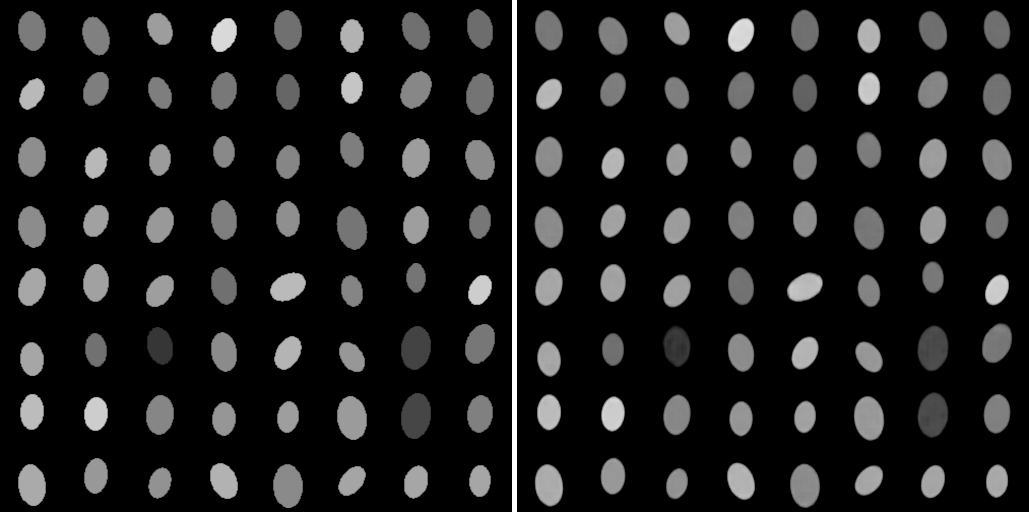

In [7]:
# first check the reconstruction images.  left: input ;   right: reconstruction
image = Image.open('./log/pvae/epoch300/test-0.png')
display(image)

In [8]:

dataloaders = get_celeba_loaders(1, 1)
with torch.no_grad():
    model.train(False)
    print(model.pe.weight)
    #exit(0)
    z_list,num_list, pos_list, rot_list, zp_list, bri_list,logit_out_list = [],[],[],[],[],[],[]


    for data in dataloaders["test"]:
        x = data[0]
        x = x.to(device)
        num_t = data[1].to(device)
        rot_t = data[2].to(device)
        pos_t = data[3].to(device)
        bri_t = data[4].to(device)
        rec_x, _, _, latent_z , zp= model(x)
        z_list.append(latent_z.unsqueeze(1))
        zp_list.append(zp.unsqueeze(1))
        bri_list.append(bri_t.unsqueeze(0))
        num_list.append(num_t.unsqueeze(0))
        rot_list.append(rot_t.unsqueeze(0))
        pos_list.append(pos_t.unsqueeze(0))

    z_list_tensor = torch.cat(z_list).squeeze(1)
    zp_list_tensor = torch.cat(zp_list).squeeze(1)
    zp_list_tensor = zp_list_tensor.squeeze(1)

    num_list_tensor = torch.cat(num_list).squeeze(1)
    bri_list_tensor = torch.cat(bri_list).squeeze(1)
    pos_list_tensor = torch.cat(pos_list).squeeze(1)
    rot_list_tensor = torch.cat(rot_list).squeeze(1)
    #exit(0)
    z_mean = torch.mean(z_list_tensor,dim=0)
    zp_mean = torch.mean(zp_list_tensor,dim=0)
    zp_std = torch.std(zp_list_tensor, dim=0)
    z_project_max,_ = torch.max(zp_list_tensor,dim=0)
    z_project_min,_ = torch.min(zp_list_tensor,dim=0)
    print('mean-3*SD, mean+3*SD:',model_lr((zp_mean-3*zp_std).unsqueeze(0)).item(), model_lr((zp_mean+3*zp_std).unsqueeze(0)).item())
    rec_tensors = torch.zeros((11,3, 64, 64))
    z_mean = z_mean.unsqueeze(0)


    flag_sampling = 1
    par_amp = 0.03
    loop_count = 0
    while flag_sampling and loop_count < 10000:      # control the sampling range to be mean+-3*SD
        loop_count = loop_count + 1
        middle_left = z_mean + par_amp*(0-5) * model.pe.weight  
        middle_right = z_mean + par_amp*(10-5) * model.pe.weight  
        middle_project_left = model.pe(middle_left)
        middle_project_right = model.pe(middle_right)
        #print(middle_project_right)
        tmp_max = torch.maximum(middle_project_left, middle_project_right)
        if torch.abs(tmp_max - (zp_mean+3*zp_std)) < 0.01:
            break
        if tmp_max - (zp_mean+3*zp_std) > 0:
            par_amp = par_amp - 0.001 
        else:
            par_amp = par_amp + 0.001

    
    points_list = []  # now start the sampling along vector p*
    for i in range(11): 
        middle = z_mean + (i-5) * model.pe.weight*par_amp 
        middle_project = model.pe(middle)
        logit_out = model_lr(middle_project)
        points_list.append(middle)
        print('brightness frame:',i+1, logit_out.item())
        rec_tensors[i] = model.decode(middle)
        rec_tensors[rec_tensors<0]=0
        rec_tensors[rec_tensors>1]=1
        imsave_inp(rec_tensors, os.path.join(logdir, f"{'frame'}-{i+1}.png"))



/home/lau/codes/env/lib/python3.6/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


Parameter containing:
tensor([[ 1.2610e+00, -1.1804e-01, -1.6376e-01,  5.0321e-05, -3.3685e-04,
          1.1382e-04,  1.3016e-04, -4.0674e-02]], device='cuda:1',
       requires_grad=True)
mean-3*SD, mean+3*SD: 0.16630962491035461 1.0067014694213867
brightness frame: 1 0.1667286604642868
brightness frame: 2 0.2506840229034424
brightness frame: 3 0.33463940024375916
brightness frame: 4 0.4185947775840759
brightness frame: 5 0.5025501847267151
brightness frame: 6 0.5865055322647095
brightness frame: 7 0.6704609394073486
brightness frame: 8 0.7544163465499878
brightness frame: 9 0.838371753692627
brightness frame: 10 0.9223271012306213
brightness frame: 11 1.0062824487686157


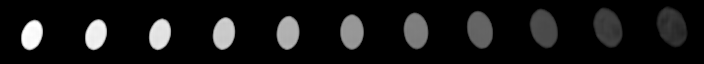

In [12]:
image = Image.open(os.path.join(logdir, f"{'frame'}-{11}.png")) 
display(image) 
# Plot the 11 frames reconstructed images along vector p*
# Range: mean+-3*SD of zp

In [14]:
input_t_list = [1.0, 0.92, 0.84, 0.76, 0.68, 0.6, 0.52, 0.44, 0.36, 0.28, 0.2] #customized input 11 values of t
input_t_list_tensor = torch.from_numpy(np.array(input_t_list)).to(device) #
value_ki_list = []
rec_tensors = torch.zeros((11,1, 64, 64))
d_mean=[]
with torch.no_grad():
    model.train(False)
        #print(model.pe.weight)
        #exit(0)
    z_list,num_list, pos_list, rot_list, zp_list, bri_list,logit_out_list = [],[],[],[],[],[],[]

    for data in dataloaders["test"]:
        x = data[0]
        x = x.to(device)
        rec_x, _, _, latent_z , zp= model(x)
        z_list.append(latent_z.unsqueeze(1))
        z_list_tensor = torch.cat(z_list).squeeze(1)

    z_mean = torch.mean(z_list_tensor,dim=0)
    d_mean_tensor = z_mean.unsqueeze(0)    
for i in range(11):
    input_t = input_t_list[i]
    with torch.no_grad():


        flag_sampling = 1
        value_ki = 0.03
        loop_count = 0
        while flag_sampling and loop_count < 10000:      # loop while err < 0.001, within 10000 iterations
            loop_count = loop_count + 1
            sampled_point = d_mean_tensor + value_ki * model.pe.weight # model.pe.weight is the vector p in manuscript 
            sampled_zp = model.pe(sampled_point)
            predicted_t = model_lr(sampled_zp)
            #print(middle_project_right)
            if torch.abs(input_t-predicted_t) < 0.001:
                break
            if corr_loss_bri < 0:
                if input_t-predicted_t > 0:  # if corr(zp, t)<0, flip this to: input_t-predicted_t > 0 
                    value_ki = value_ki - 0.001 
                else:
                    value_ki = value_ki + 0.001
            else:
                if input_t-predicted_t < 0:  # if corr(zp, t)<0, flip this to: input_t-predicted_t > 0 
                    value_ki = value_ki - 0.001 
                else:
                    value_ki = value_ki + 0.001

        value_ki_list = np.append(value_ki_list,value_ki)

        sampled_point = d_mean_tensor +  value_ki* model.pe.weight 
        sampled_zp = model.pe(sampled_point)
        predicted_t = model_lr(sampled_zp)
        print('The predicted brightness of frame',i+1, predicted_t.item())
        rec_tensors[i] = model.decode(sampled_point)
        rec_tensors[rec_tensors<0]=0
        rec_tensors[rec_tensors>1]=1
        imsave_inp(rec_tensors, os.path.join(logdir, f"{'frame'}-{i+1}.png"))


 


The predicted brightness of frame 1 0.9991397857666016
The predicted brightness of frame 2 0.9190403819084167
The predicted brightness of frame 3 0.8391162753105164
The predicted brightness of frame 4 0.7590168714523315
The predicted brightness of frame 5 0.6790927052497864
The predicted brightness of frame 6 0.599168598651886
The predicted brightness of frame 7 0.5209972262382507
The predicted brightness of frame 8 0.4408978223800659
The predicted brightness of frame 9 0.3609737157821655
The predicted brightness of frame 10 0.2808743119239807
The predicted brightness of frame 11 0.20095022022724152


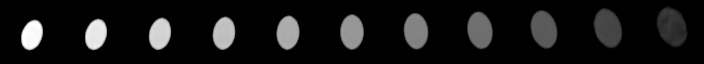

In [15]:
image = Image.open(os.path.join(logdir, f"{'frame'}-{11}.png"))
display(image)
# Plot the 11 frames reconstructed images along vector p*
# fix range customized by user [1.0, 0.92, 0.84, 0.76, 0.68, 0.6, 0.52, 0.44, 0.36, 0.28, 0.2]